#Conectamos a google drive e importamos librerias

In [ ]:
# Se conecta al Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle #para guardado de datos
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D,RandomFlip,RandomRotation,MaxPool2D
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Para importar el Helper
%cd "/content/drive/Shareddrives/Redes neuronales/TP3"
!pip install import-ipynb
import import_ipynb
from Helper import *

/content/drive/Shareddrives/Redes neuronales/TP3
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=c510456819ae3d0988ffeb1f7b87cb91dc01cab1904d2a38c0392fb3b7e634ef
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Helper.ipynb
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                

# Cargamos los datos

In [ ]:
X_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_train.npy")
Y_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/y_train.npy")
X_test = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_test.npy")

# Dividimos entre datasets de entrenamiento y validación

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.1)

# Paso a float

In [ ]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [ ]:
y_train_categorical = to_categorical(y_train,100)
y_val_categorical = to_categorical(y_valid,100)

Se normalizan los valores de las imagenes y se pasa a categorica los labels del to_categorical

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization= False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 50,  # randomly rotate images in the range (degrees, 0 to 180) #30
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height) #0.1
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


x_train_pp = x_train
datagen.fit(x_train_pp)

# x_test_pp = x_test
# datagen.fit(x_test_pp)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Se crea el ImageDataGenerator

A continuación se instancia la arquitectura del modelo MobileNET

In [ ]:
preproc=tf.keras.applications.MobileNet(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))
preproc.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32) 

Se decide que no se entrenen los pesos de preproc

In [ ]:
for layer in preproc.layers:
    layer.trainable=False

In [ ]:
x_pre_train=preproc.predict(x_train_pp)
x_pre_valid=preproc.predict(x_valid)

In [ ]:
x_pre_train[0].shape

(1, 1, 1024)

In [ ]:
input_preproc=Input(shape=(1,1,1024))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net) #256
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net) #256
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1, 1024)]      0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               2570

In [ ]:
# Callbacks
checkpoint_file =f"/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_MobileNET_batch_size64_epocs100_neuronas256_mejorTere.hdf5"

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

Se entrena la primera parte de la red

In [ ]:
batch_size = 64
epocs = 100

history = model.fit(x_pre_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_pre_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
702/704 [============================>.] - ETA: 0s - loss: 4.6017 - accuracy: 0.0110
Epoch 00001: val_accuracy improved from -inf to 0.01280, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_MobileNET_batch_size64_epocs100_neuronas256_mejorTere.hdf5
704/704 [==============================] - 4s 6ms/step - loss: 4.6017 - accuracy: 0.0110 - val_loss: 4.5894 - val_accuracy: 0.0128
Epoch 2/100
703/704 [============================>.] - ETA: 0s - loss: 4.5842 - accuracy: 0.0163
Epoch 00002: val_accuracy improved from 0.01280 to 0.02320, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning_dataaug_MobileNET_batch_size64_epocs100_neuronas256_mejorTere.hdf5
704/704 [==============================] - 3s 4ms/step - loss: 4.5842 - accuracy: 0.0164 - val_loss: 4.5703 - val_accuracy: 0.0232
Epoch 3/100
697/704 [============================>.] - ETA: 0s - loss: 4.5644 - accuracy:

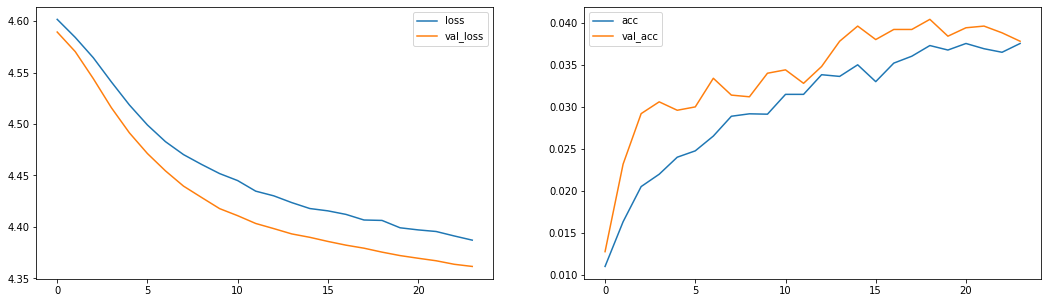

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();

Se cargan los pesos del mejor epochs antes calculado

In [ ]:
model.load_weights(checkpoint_file)

Se crea el modelo total

In [ ]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

Se establece que ahora los pesos de los layers del modelo sean entrenables

In [ ]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

In [ ]:
total_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Callbacks
checkpoint_file=f'/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-MobileNET_fine_tunning_batch_size{batch_size}_epocs{epocs}_optimizer"sgd"_neuronas256_mejorTere.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

Se entrena la red entera

In [ ]:
batch_size = 64
epocs = 100

history = total_model.fit(x_train_pp, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
704/704 [==============================] - ETA: 0s - loss: 4.1316 - accuracy: 0.0824
Epoch 00001: val_accuracy improved from -inf to 0.16520, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-MobileNET_fine_tunning_batch_size64_epocs100_optimizer"sgd"_neuronas256_mejorTere.hdf5
704/704 [==============================] - 26s 31ms/step - loss: 4.1316 - accuracy: 0.0824 - val_loss: 3.5139 - val_accuracy: 0.1652
Epoch 2/100
703/704 [============================>.] - ETA: 0s - loss: 3.3843 - accuracy: 0.1847
Epoch 00002: val_accuracy improved from 0.16520 to 0.22520, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-MobileNET_fine_tunning_batch_size64_epocs100_optimizer"sgd"_neuronas256_mejorTere.hdf5
704/704 [==============================] - 21s 30ms/step - loss: 3.3844 - accuracy: 0.1847 - val_loss: 3.2212 - val_accuracy: 0.2252
Epoch 3/100
703/704 [============================>.